#**Submission Image Classification & Deployment**

Pada submission ini saya akan membuat model untuk memprediksi gambar-gambar intel (glacier, laut, hutan, jalanan, gunung, dan bangunan ). Total ada 6 kelas. Dataset yang saya gunakan dapat diakses pada link di bawah ini:

https://www.kaggle.com/puneet6060/intel-image-classification

In [52]:
#install kaggle untuk mendapatkan akses ke dataset
!pip install kaggle

In [53]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"*********","key":"*************"}'}

In [54]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [55]:
!kaggle datasets download -d puneet6060/intel-image-classification

 99% 344M/346M [00:13<00:00, 22.6MB/s]
100% 346M/346M [00:15<00:00, 23.5MB/s]


In [56]:
import os, zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Dropout, Conv2D
from tensorflow.keras.models import Sequential
from keras.applications import VGG16

In [59]:
#ekstrak file
path = '/content/intel-image-classification.zip'
zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/seg_train/seg_train'

In [71]:
#mengolah gambar dengan image data generator
generator = ImageDataGenerator(rescale=1/255,
                               validation_split=0.2)


train_dataset = generator.flow_from_directory(batch_size=20,
                                                    directory=base_dir,
                                                    target_size=(150,150),
                                                    subset='training',
                                                    class_mode='categorical')

val_dataset = generator.flow_from_directory(batch_size=20,
                                                directory=base_dir,
                                                target_size=(150,150),
                                                subset='validation',
                                                class_mode='categorical')


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [72]:
#Membuat callback
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>0.9):
        print("\nPelatihan Berhenti Karena Akurasi telah mencapai >90%")
        self.model.stop_training = True
callback = Callback()  

In [94]:
#membuat model (saya menambahkan model VGG16 ke dalam model sekuensial)
conv_base = VGG16(
                  weights = 'imagenet',
                  include_top = False,
                  input_shape = (150,150,3)
                 )
#Di dalam model ini sudah terdapat layer Conv2D dan Maxpooling2D
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [95]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(250, activation='relu'))                    
model.add(Dropout(0.5))
model.add(Dense(6,activation='softmax'))

In [97]:
#compile dan fit model
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=tf.optimizers.Adam(lr=2e-5))

history=model.fit(train_dataset,
                  epochs=30,
                  validation_data=val_dataset,
                  verbose=1,
                  callbacks=[callback],
                  steps_per_epoch=30,
                  validation_steps=30)

Epoch 1/30
 2/30 [=>............................] - ETA: 4s - loss: 1.8039 - accuracy: 0.1500WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1283s vs `on_train_batch_end` time: 0.2114s). Check your callbacks.


30/30 [==============================] - 13s 429ms/step - loss: 1.7535 - accuracy: 0.2183 - val_loss: 1.6770 - val_accuracy: 0.3383
Epoch 2/30
30/30 [==============================] - 13s 420ms/step - loss: 1.6810 - accuracy: 0.2850 - val_loss: 1.5728 - val_accuracy: 0.3683
Epoch 3/30
30/30 [==============================] - 13s 422ms/step - loss: 1.5352 - accuracy: 0.3383 - val_loss: 1.3834 - val_accuracy: 0.4033
Epoch 4/30
30/30 [==============================] - 13s 424ms/step - loss: 1.4255 - accuracy: 0.4050 - val_loss: 1.2448 - val_accuracy: 0.4850
Epoch 5/30
30/30 [==============================] - 13s 424ms/step - loss: 1.3020 - accuracy: 0.4467 - val_loss: 1.0267 - val_accuracy: 0.6550
Epoch 6/30
30/30 [==============================] - 13s 426ms/step - loss: 1.1760 - accuracy: 0.4800 - val_loss: 1.0250 - val_accuracy: 0.5433
Epoch 7/30
30/30 [==============================] - 13s 427ms/step - loss: 1.0559 - accuracy: 0.5133 - val_loss: 0.8986 - val_accuracy: 0.6517
Epoch 8/30

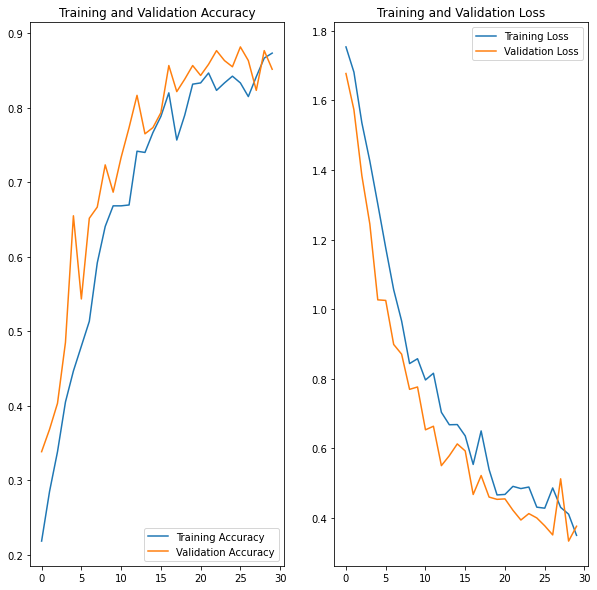

In [99]:
#visualisasi 
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(30) 
plt.figure(figsize=(10, 10))

#visualisasi training and validation accurancy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#visualisasi training and validation loss 
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [100]:
# Mengkonversi model menjadi .tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpau3rp1hc/assets


INFO:tensorflow:Assets written to: /tmp/tmpau3rp1hc/assets


Saving New_york_times_building.jpg to New_york_times_building.jpg
New_york_times_building.jpg
BUILDING


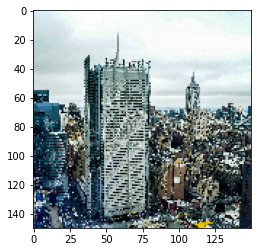

In [102]:
#test model
import numpy as np
from keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # prediksi gambar
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=20)

  print(fn)
  if np.all(classes == [1,0,0,0,0,0]):
    print('BUILDING')
  elif np.all(classes == [0,1,0,0,0,0]):
    print('FOREST')
  elif np.all(classes == [0,0,1,0,0,0]):
    print('GLACIER')
  elif np.all(classes == [0,0,0,1,0,0]):
    print('MOUNTAIN') 
  elif np.all(classes == [0,0,0,0,1,0]):
    print('SEA')
  elif np.all(classes == [0,0,0,0,0,1]):
    print('STREET')     
  else:
    print('error') 